In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import OneHotEncoder


In [7]:
from google.colab import files

uploaded2 = files.upload()

for fn in uploaded2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded2[fn])))

Saving archive(11).zip to archive(11).zip
User uploaded file "archive(11).zip" with length 26966759 bytes


In [13]:
import zipfile
import io

# Assuming uploaded2 contains the zip file content
zip_file_name = list(uploaded2.keys())[0]
zip_file_content = uploaded2[zip_file_name]

# Use BytesIO to treat the bytes content as a file
with zipfile.ZipFile(io.BytesIO(zip_file_content), 'r') as zip_ref:
    zip_ref.extractall('.') # Extract to the current directory

print(f"Files extracted from {zip_file_name}")

Files extracted from archive(11).zip


In [14]:
import pandas as pd
import os
data = []
# Use the current directory '.' as the extraction path
extract_path = '.'
for filename in os.listdir(extract_path):
    if filename.endswith(".txt"):
        # Remove the '.txt' extension to get the label
        label = filename.replace(".txt", "")
        # Construct the full file path
        file_path = os.path.join(extract_path, filename)
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read()
        data.append({"label": label, "text": text})

df = pd.DataFrame(data)
print(f"✅ Loaded {df.shape[0]} documents across {df['label'].nunique()} categories.")
df.head()

✅ Loaded 20 documents across 20 categories.


label                                               text
0  comp.sys.mac.hardware  Newsgroup: comp.sys.mac.hardware\ndocument_id:...
1          comp.graphics  From: lipman@oasys.dt.navy.mil (Robert Lipman)...
2       rec.sport.hockey  Newsgroup: rec.sport.hockey\ndocument_id: 5255...
3           misc.forsale  Newsgroup: misc.forsale\ndocument_id: 70337\nF...
4     talk.politics.guns  Newsgroup: talk.politics.guns\ndocument_id: 53...

In [17]:

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])

print("🔹 Raw TF-IDF shape:", X_tfidf.shape)

🔹 Raw TF-IDF shape: (20, 5000)


In [20]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

print("🔹 After SVD shape:", X_svd.shape)


🔹 After SVD shape: (20, 2)


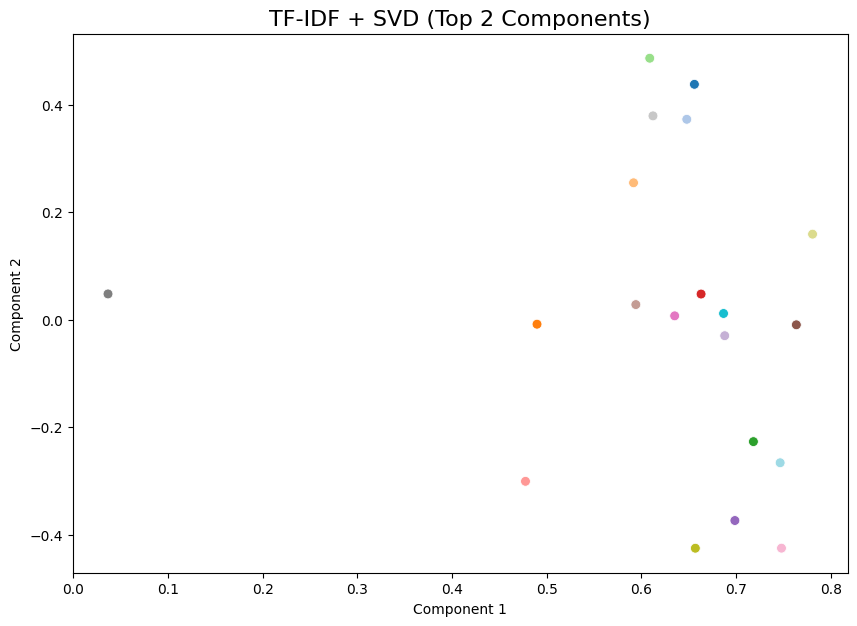

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=df['label'], palette='tab20', legend=False, s=50)
plt.title("TF-IDF + SVD (Top 2 Components)", fontsize=16)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


 Silhouette Score (10 clusters): 0.1134


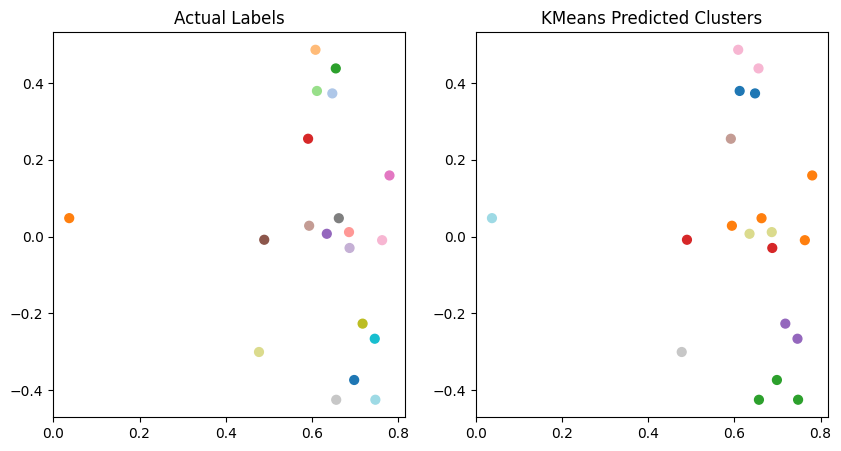

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# Reduce the number of clusters to be less than the number of samples
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10) # Added n_init for KMeans
pred_clusters = kmeans.fit_predict(X_tfidf)

sil_score = silhouette_score(X_tfidf, pred_clusters)
print(f" Silhouette Score (10 clusters): {sil_score:.4f}")

# Encode actual labels to numbers
le = LabelEncoder()
true_labels = le.fit_transform(df['label'])

# Compare predicted vs actual in scatter plots
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=true_labels, cmap='tab20', s=40)
plt.title("Actual Labels")

plt.subplot(1, 2, 2)
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=pred_clusters, cmap='tab20', s=40)
plt.title("KMeans Predicted Clusters")

plt.show()